In [1]:
%load_ext autoreload


In [2]:
from times_series_workflow import *
from clean_data import clean
import matplotlib.pyplot as plt
btc_data=pd.read_csv("data/BTCUSDT.csv")
btc_data.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1640991600000,46303.98,46467.67,46300.49,46350.44,465.18072,1640993399999,2.158094e+07,13399,211.34079,9.805458e+06,0
1,1640993400000,46350.44,46520.13,46132.04,46216.93,520.81690,1640995199999,2.413883e+07,16156,272.75150,1.264373e+07,0
2,1640995200000,46216.93,46527.26,46208.37,46375.42,706.65682,1640996999999,3.275119e+07,19674,388.44942,1.800036e+07,0
3,1640997000000,46375.42,46731.39,46360.19,46656.13,796.67413,1640998799999,3.712879e+07,18934,417.61594,1.946179e+07,0
4,1640998800000,46656.14,46949.99,46574.06,46815.33,589.50801,1641000599999,2.754998e+07,18930,332.64016,1.554390e+07,0


In [3]:
btc_data=clean(btc_data)

In [4]:
btc_data.head()

,open,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,
2021-12-31 23:00:00,46303.98,46350.44,465.18072,2021-12-31 23:29:59.999,2.158094e+07,13399,211.34079,9.805458e+06
2021-12-31 23:30:00,46350.44,46216.93,520.81690,2021-12-31 23:59:59.999,2.413883e+07,16156,272.75150,1.264373e+07
2022-01-01 00:00:00,46216.93,46375.42,706.65682,2022-01-01 00:29:59.999,3.275119e+07,19674,388.44942,1.800036e+07
2022-01-01 00:30:00,46375.42,46656.13,796.67413,2022-01-01 00:59:59.999,3.712879e+07,18934,417.61594,1.946179e+07
2022-01-01 01:00:00,46656.14,46815.33,589.50801,2022-01-01 01:29:59.999,2.754998e+07,18930,332.64016,1.554390e+07


import statsmodels.api as sm
import matplotlib.pyplot as plt

# Realizar la descomposición estacional
decomposition = sm.tsa.seasonal_decompose(btc_data[["close"]].asfreq(freq="D"), model='additive')

# Obtener las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Graficar las componentes
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(btc_data["close"])
axes[0].set_ylabel('Original')
axes[1].plot(trend)
axes[1].set_ylabel('Tendencia')
axes[2].plot(seasonal)
axes[2].set_ylabel('Estacionalidad')
axes[3].plot(residual)
axes[3].set_ylabel('Residuos')
plt.tight_layout()
plt.show()




In [5]:
check_stationarity(btc_data["close"])

The 'close' column is not stationary.


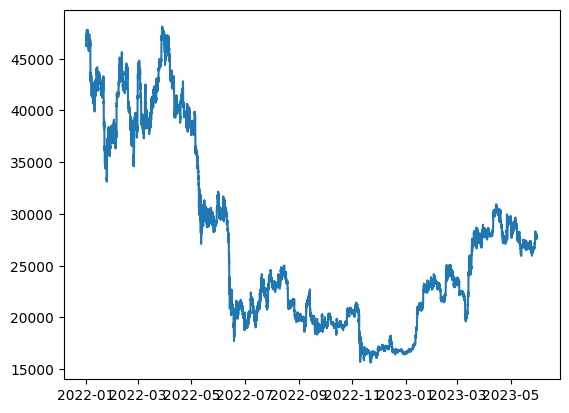

In [6]:
plt.plot(btc_data["close"])

Text(0.5, 1.0, '1st Order Differencing')

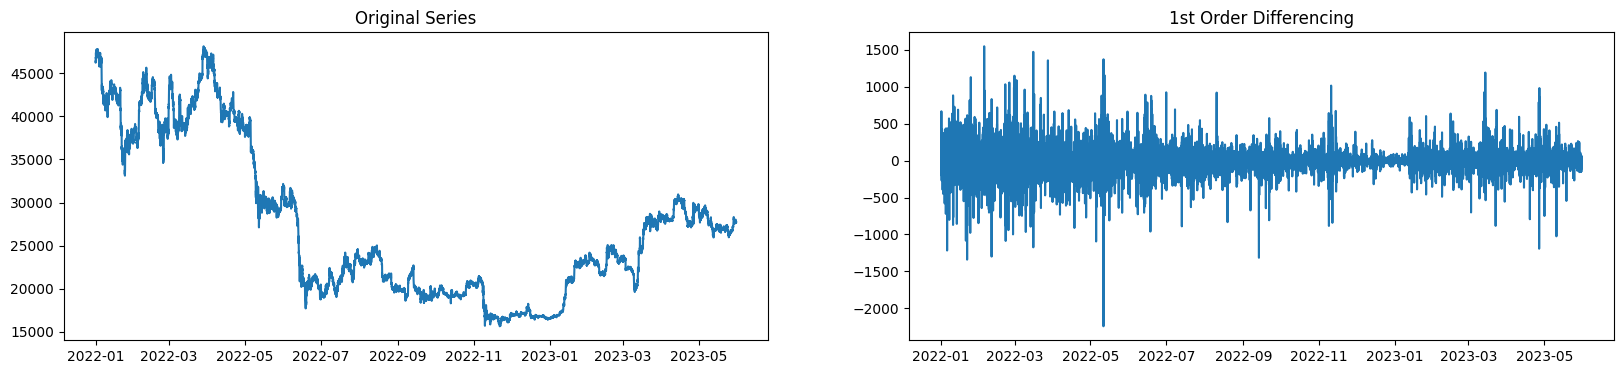

In [8]:
#remove_stationarity
    # Perform differencing
btc_data["close_diff"] = btc_data.close.diff(1).fillna(0)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
ax1.plot(btc_data["close"]); ax1.set_title('Original Series')
ax2.plot(btc_data["close_diff"]); ax2.set_title('1st Order Differencing')

In [10]:
btc_data[["close_diff"]]

,close_diff
open_time,
2021-12-31 23:00:00,0.00
2021-12-31 23:30:00,-133.51
2022-01-01 00:00:00,158.49
2022-01-01 00:30:00,280.71
2022-01-01 01:00:00,159.20
...,...
2023-05-30 20:00:00,-52.96
2023-05-30 20:30:00,-34.73
2023-05-30 21:00:00,57.27


btc_data_nostat = pd.DataFrame({
    "close": btc_data["close"].diff().fillna(0)
})
btc_data_nostat.head()

In [12]:
check_stationarity(btc_data["close_diff"])

The 'close' column is stationary.


/home/yass/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


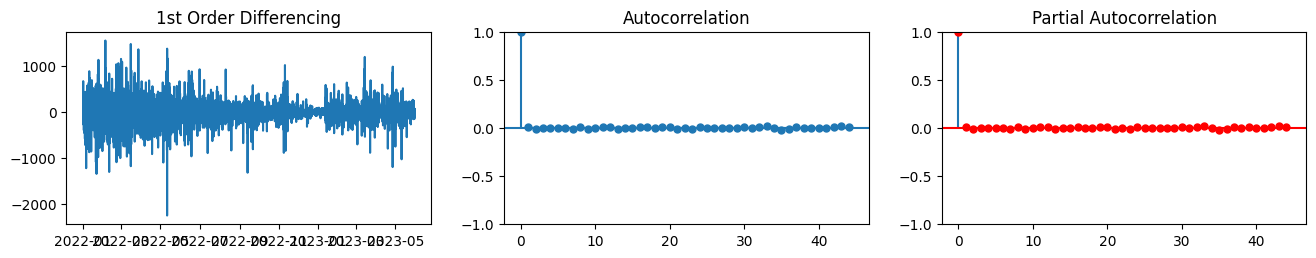

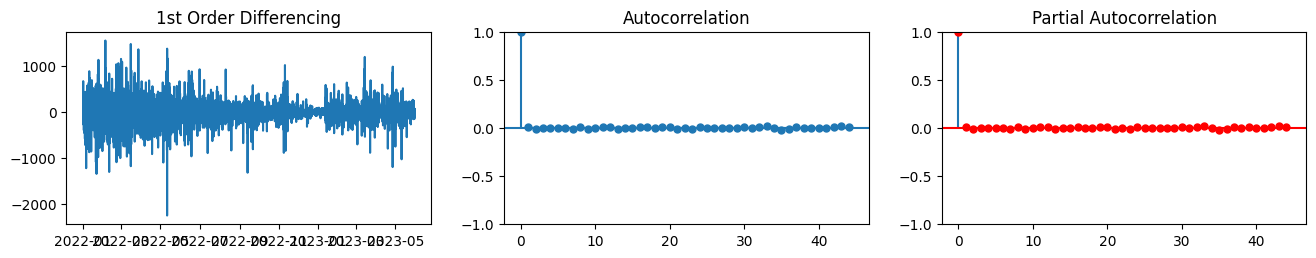

In [16]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(btc_data["close_diff"]); axes[0].set_title('1st Order Differencing')
plot_acf(btc_data["close_diff"], ax=axes[1]);
plot_pacf(btc_data["close_diff"], ax=axes[2], c='r')

In [13]:
train_data,test_data=split_data(btc_data["close_diff"], train_ratio=0.8)

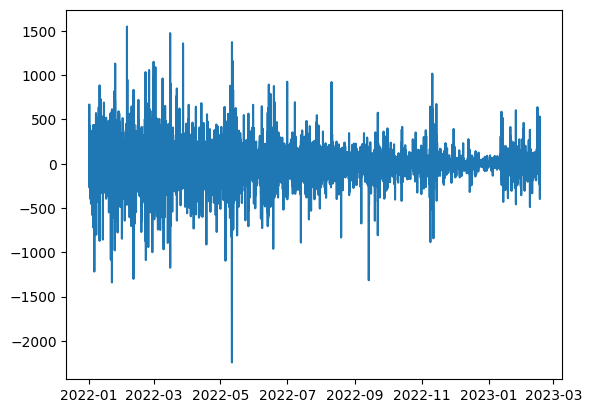

In [14]:

plt.plot(train_data)

In [37]:
model=model = pm.auto_arima(btc_data["close_diff"],
                       start_p=0, max_p=2,
                       start_q=0, max_q=2,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=311111.311, Time=4.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=311112.034, Time=4.94 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=311112.004, Time=5.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=311113.041, Time=8.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=311111.311, Time=4.94 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 28.103 seconds


In [38]:
from statsmodels.tsa.arima.model import ARIMA

# Build model
arima = ARIMA(train_data, order=(0, 0, 0), trend='t')  
arima = arima.fit()


/home/yass/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/home/yass/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/home/yass/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


In [39]:
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             close_diff   No. Observations:                19773
Model:                          ARIMA   Log Likelihood             -125423.850
Date:                Thu, 08 Jun 2023   AIC                         250851.701
Time:                        12:26:48   BIC                         250867.485
Sample:                    12-31-2021   HQIC                        250856.867
                         - 02-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.749e-05      0.000     -0.207      0.836      -0.000       0.000
sigma2      1.893e+04     61.768    306.469      0.000    1.88e+04    1.91e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):            238886.40
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
## Forecast
# Forecast values
forecast = arima.forecast(len(test_data), alpha=0.05)  # 95% confidence

In [54]:
print(forecast)

2023-02-16 21:30:00   -0.543506
2023-02-16 22:00:00   -0.543533
2023-02-16 22:30:00   -0.543561
2023-02-16 23:00:00   -0.543588
2023-02-16 23:30:00   -0.543616
                         ...   
2023-05-30 19:00:00   -0.679259
2023-05-30 19:30:00   -0.679286
2023-05-30 20:00:00   -0.679314
2023-05-30 20:30:00   -0.679341
2023-05-30 21:00:00   -0.679369
Freq: 30T, Name: predicted_mean, Length: 4944, dtype: float64


In [55]:
test_data

open_time
2023-02-16 21:30:00     58.66
2023-02-16 22:00:00   -179.22
2023-02-16 22:30:00   -363.06
2023-02-16 23:00:00   -137.72
2023-02-16 23:30:00   -339.32
                        ...  
2023-05-30 20:00:00    -52.96
2023-05-30 20:30:00    -34.73
2023-05-30 21:00:00     57.27
2023-05-30 21:30:00   -100.41
2023-05-30 22:00:00      5.84
Name: close_diff, Length: 4944, dtype: float64

In [41]:
# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test_data), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

In [45]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(train, label='training', color='blue')  # Cambiar color a azul
    plt.plot(test, label='actual', color='green', ls='--')  # Cambiar color a verde y estilo de línea a discontinua
    plt.plot(fc_series, label='forecast', color='red')  # Cambiar color a rojo
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='purple', alpha=0.15)  # Cambiar color a morado
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)


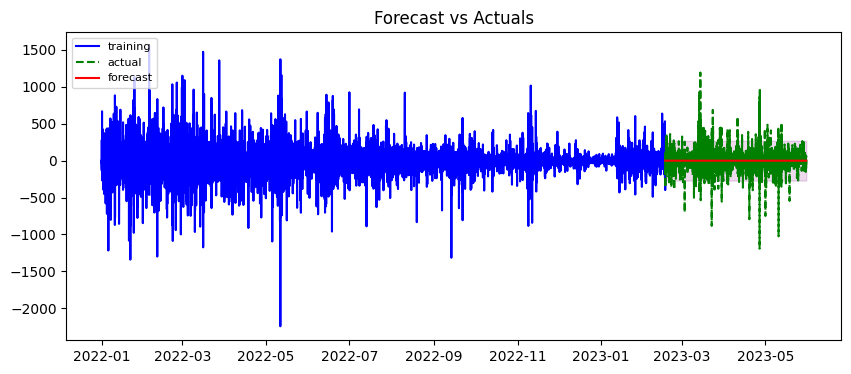

In [46]:
plot_forecast(forecast, train_data, test_data, confidence_int[:,0], confidence_int[:,1])
